# Task 4
In this task 4, we will observe the change in fidelity according to the systematic error.  
For simplicity, We make a random parameter vector for smae random circuit,  
and for each shot, we reconstruct the random circuit for randomly adding/substractng systematic errors.

## Preliminaries  
First of all, import all necessary packages.

In [1]:
using PastaQ
using ITensors
using PyPlot
using Random

Take run_random_circuit.jl file contents.

In [2]:
#From run_random_circuit.jl
function PastaQ.gate(::GateName"R"; theta::Real, phi::Real)
    [
        cos(theta/2)    (-im * exp(-im * phi) * sin(theta/2))
        (-im * exp(im * phi) * sin(theta/2))     cos(theta/2)
    ]
end

function PastaQ.gate(::GateName"M"; Theta::Real)
    [
        cos(Theta)    0    0    (-im * sin(Theta))
        0    cos(Theta)    (-im * sin(Theta))    0
        0    (-im * sin(Theta))    cos(Theta)    0
        (-im * sin(Theta))    0    0    cos(Theta)
    ]
end

function run(N, depth)
    # Random circuit.
    gates = Vector{Tuple}[]

    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=2pi*rand(), phi=2pi*rand()))
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=2pi*rand(),))
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end

    psi = runcircuit(N, gates)
end

run (generic function with 1 method)

Function to extract values from pair.

In [3]:
# Since each data matrix compoenets have "Pair"- We just want to get only values.
# Function to extract values from pair

function getValue(P::Pair)
    return P[2]
end

getValue (generic function with 1 method)

To represent results of qubits, function to decimal integer from vectors of binary representation.

In [4]:
# Convert Matrix -> Vector to extract information easily
function BinaryToDecimal(M,N)
    idx = zeros(Int8,size(M)[1],1)
    for i in 1:N
        idx += M[:,i].*2^(i-1)
    end
    
    return idx
end

BinaryToDecimal (generic function with 1 method)

Function for creating 'empty' count dictionary;  
Each keys are decimal representation of qubits, and each values are counted number of result of shots.

In [5]:
# Generate initial Count dictionary
function Init_Count_Generator(N)
    Count = Dict{Int64,Int64}()
    for i in 0:2^N-1
        push!(Count,i=>0)
    end

    return Count = sort((Count))
end   

Init_Count_Generator (generic function with 1 method)

From the Count dictionary, convert from the number of count to ratio of frequqency; probability.

In [6]:
# Get Probabilities dictionary
function get_probabilities(Count,N)
    Prob = Dict{Int64,Float64}()
    Total_shots = sum(values(Count))
    for i in 0:2^N-1
        push!(Prob,i=>(Count[i]/Total_shots))
    end
    
    return sort(Prob)
end

get_probabilities (generic function with 1 method)

From the deicaml representation, recording the results of shots to count dictionary.

In [7]:
function get_counts(Count,V)
    Keys = keys(Count)
    for k in Keys
        Count[k]+=count(i->(i==k),V)
    end
    return Count
end


get_counts (generic function with 1 method)

From the random circuit result to decimal representation.

In [8]:
# From sampling of state to Decimal representation vector
function execute(ψ,N,shots)
    data = getsamples(ψ, shots ,local_basis=["Z"])
    B = getValue.(data)
    C = BinaryToDecimal(B,N)
    return C
end

execute (generic function with 1 method)

We modify the run function from run_random_circuit to add effect of systematic error  
and specify the random parameters.

In [9]:
function run_(N, depth,rand_params,Δ)
    # Random circuit.
    rand_idx = 1
    gates = Vector{Tuple}[]
    
    for i in 1:depth
        one_qubit_layer = Tuple[]
        two_qubit_layer = Tuple[]

        for j in 1:N
            gate = ("R", j, (theta=rand_params[rand_idx], phi=rand_params[rand_idx+1]))
            rand_idx+=2
            push!(one_qubit_layer, gate)
        end

        # Alternate start qubit for pairs.
        idx_first = i % 2 + 1

        for j in idx_first:2:(N-1)
            gate = ("M", (j, j+1), (Theta=rand_params[rand_idx]+Δ*(Int(bitrand()[1])*2-1),))
            rand_idx += 1
            push!(two_qubit_layer, gate)
        end

        push!(gates, one_qubit_layer)
        push!(gates, two_qubit_layer)
    end

    psi = runcircuit(N, gates)
end

run_ (generic function with 1 method)

Random parameters to specified the random circuit.

In [ ]:
rand_params = rand(Float64,(50000,1))*2pi

The function below is 'bnchmarked' in the cirq documentation :  
https://quantumai.google/cirq/qcvv/xeb_theory  
It covers all the kind of errors which causes the channel or systematic error simulations.

In [11]:
# XEF is function for Cross Entropy Benchmarking Fidelity.
function e_u(Prob_0)
    e_u = 0
    for i in 0:2^N-1
        e_u +=Prob_0[i]^2
    end
    
    return e_u
end

function m_u(Prob_0,Prob)
    m_u = 0
    for i in 0:2^N-1
        m_u += Prob_0[i]*Prob[i]
    end
    
    return m_u
end

function XEF(Prob_0,Prob)
    E_u = e_u(Prob_0)
    M_u = m_u(Prob_0, Prob)
    U_u = 1/(2^N)
    f = (M_u-U_u)/(E_u - U_u)
    return f
end

XEF (generic function with 1 method)

## main part of the solution

In this task, We fix the number of qubits N = 4,  
But we choose several Depth for the effect of depths, also.  
we gave system error [0.0, 1.0] to the circuit

In [ ]:
Δ_ = Vector{Float64}()
N = 4 # The number of Qubit
D_ = Vector{Int64}([1,5,10,20,50]) # Depths of Circuit
shots = 1024 # The number of shot
XEF_ = Vector{Float64}()



for i in 0:100
    push!(Δ_,i*0.01)
end

for D in D_ 
    Prob_0 = Dict{Int64,Float64}()
    Prob = Dict{Int64,Float64}()
    j = 0
    for Δ in Δ_
        println("Δ : ",Δ)
        Count = Init_Count_Generator(N) # Dictionary for counting result
        for i in 1:shots
            if i%100 == 0
                println(i)
            end
            ϕ = run_(N,D,rand_params,Δ) # Get state
            shot_result = execute(ϕ,N,1) # Get decimal representation of shot result(Vector)
            Count = get_counts(Count,shot_result) # Get Counts from shot_result
        end

        if j == 0
            println("First")
            Prob_0 = get_probabilities(Count,N) # Get probabilities from Count
            xef = XEF(Prob_0,Prob_0)
            push!(XEF_,xef)
            j+=1
        else 
            Prob = get_probabilities(Count,N)
            xef = XEF(Prob_0,Prob)
            push!(XEF_,xef)
        end
    end
end

In [ ]:
XEF_ = reshape(XEF_,(505,1))
@show XEF_

We observe that when systematic error increases the fidelity decrease;
Systematic error effect to the fidelity.
And as the number of depth increases, systematic error drive fidelity to the 0 faster.  
Finally, when sufficiently deep depth, we can see that the effect of Porter-Thomas distribution in the fidelity.

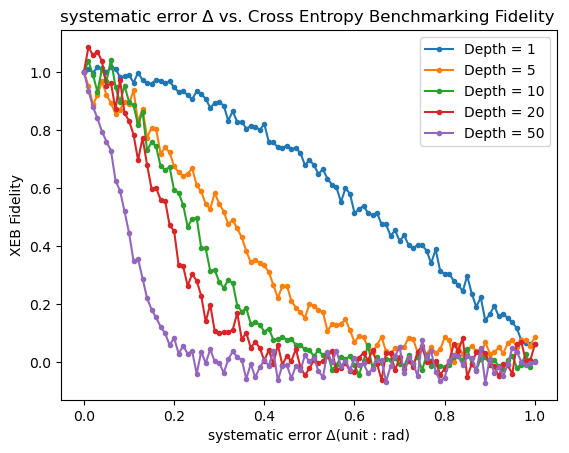

PyObject <matplotlib.legend.Legend object at 0x00000000018801F0>

In [46]:
title("systematic error Δ vs. Cross Entropy Benchmarking Fidelity ")
plt.xlabel("systematic error Δ(unit : rad)")
plt.ylabel("XEB Fidelity")

for i in 0:4
    plot(Δ_,XEF_[i*101+1:(i+1)*101,1],marker=".",label="Depth = "*string(D_[i+1]))
end

legend()